# Zero to Hero Machine Learning Pipeline: London Airbnb Open Data

### Table of Content
- [Introduction](#introduction)
- [Dataset](#dataset)
  - [Data Cleaning](#data-cleaning)
  - [Data Dictionary](#data-dictionary)
- [EDA](#eda)


## Introduction
**"He was no one, Zero, Zero
Now he's a honcho, He's a hero, hero!"**

Isn't this familiar? Absolutely it is. No way you could forger about Disney's cool animation, Hercules.


<p align="center">
  <img src="https://static.wikia.nocookie.net/disney/images/f/fa/Zero_to_Hero.png" alt="Hercules" width="100%"/>
</p>

Fig 1: Charming Hercules ([Source](https://disney.fandom.com/wiki/Zero_to_Hero))

"Zero to Hero" is a phrase that is often used to describe a transformation from a novice or beginner to an expert or accomplished individual. It can also refer to a person who starts with very little and through hard work and determination, becomes successful. Throughout this journey, I want to take you to a step-by-step guide on building a regression Machine Learning pipeline.

This mini-project is about building a regression pipeline to predict the number of `reviews per month` as a proxy for the popularity of the listing, trained based on a dataset collected on September 2022 in London.

## Dataset
Airbnb is an online marketplace that connects people who need a place to stay with people who have a spare room or an entire home to share. The platform allows property owners to rent out their properties to travelers, who can book the properties through the Airbnb website or mobile app. 
The dataset to build this pipeline was captured from [Detailed Airbnb Listing Data (London, Sep 2022)](https://www.kaggle.com/datasets/mrnabiz/detailed-airbnb-listing-data-london-sep-2022) on Kaggle. The original data was prepared by [Inside Airbnb project](http://insideairbnb.com/). The mission of Inside Airbnb is to empower residential communities with data and information that enables them to understand, make decisions and have control over the effects of Airbnb's presence in their neighborhoods.

Some of the data that is typically included in the Inside Airbnb dataset includes property information (like the property's location, price, number of bedrooms and bathrooms, and amenities) and review information (like the date of the review, the rating given by the guest, and the text of the review).
The Inside Airbnb dataset can be used for various purposes like market analysis, demand forecasting, price optimization, and much more.

After retrieving the dataset with the [`pull_data.py`](https://github.com/mrnabiz/zero-to-hero-ml-pipline/blob/main/src/data_wrangling/pull_data.py) script, it is the time to clean the data.

### Data Cleaning
In this step, two scripts [`clean_data.py`](https://github.com/mrnabiz/zero-to-hero-ml-pipline/blob/main/src/data_wrangling/clean_data.py) and [`preprocessing.py`](https://github.com/mrnabiz/zero-to-hero-ml-pipline/blob/main/src/data_wrangling/preprocessing.py) for data cleaning and data preprocessing purposes. The major cleaning task are:
- Removing irrelevant or ID-based columns like `listing_url`, `neighborhood_overview`, `host_id`, `host_url`, `host_name`, and etc.
- Dropping the null values
- Transferring `last_review` and `host_since` date columns into datetime object
- Removing the `$` and `,` from the `price` column and changing its type to float
- Removing the `[]` and `"` characters from `amenities` column to prepare it for countvectorizer.

### Data Dictionary
This raw dataset includes 69351 entries and has 52 columns. After the data cleaning and data wrangling step we end of having 51726 observations and 23 columns. Some of the most important columns are:
- `host_since`: The date when he host joined AirBnb
- `room_type`: The type of the rental property, Entire home or Private room
- `neighbourhood_cleansed`: The name of the neighbourhood
- `minimum_nights`: The minimum required nights for booking
- `maximum_nights`: Maximum allowed nights for booking
- `minimum_nights_avg_ntm`: Average minimum nights booked
- `maximum_nights_avg_ntm`: Average maximum nights booked
- `number_of_reviews`: Total number of current reviews of the property
- `last_review`: The date of the last review the property received
- `reviews_per_month` (target) and `last_review` show some null values related to the properties with zero reviews. So the null values of both of these features will be dropped since we know that for `reviews_per_month` equal to zero, we observe the null values in the aforementioned feature.

## EDA
Based on an initial EDA of the dataset, it seems that the target column `reviews_per_month` is showing a skewed distribution, so target column transformation might be necessary for this problem.

Based on the correlation matrix, the target shows a higher correlation with `availability_365` and `number_of_reviews`, which seems reasonable. The properties with a higher number of reviews are the ones that were more popular and active, so they probably have a higher `reviews_per_month`. There are three types of properties, and the `entire home/apt` has the most observations. On the other hand, the pair-wise correlation of the features and the target also shows the correlation between factors.
Based on the nature of the problem (regression) and the nature of the target, the metrics below will be chosen to assess the models:
- $R^2$: The coefficient of determination to calculate the ratio between the variance of the model prediction and total variance. I will use this score for the model and hyperparameter optimization.
- RMSE, MSE: These two metrics will also be used for reporting purposes. Here the MSE is the least interesting metric since its units are squared.

In [1]:
import numpy as np
import pandas as pd
import altair as alt
from datetime import (
    datetime,
    timedelta
)

import nltk
nltk.download("vader_lexicon")
nltk.download("punkt")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore",category=LinAlgWarning)
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    RFECV,
    SelectFromModel
)
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
    TransformedTargetRegressor
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    PolynomialFeatures
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    Ridge,
    RidgeCV,
    LinearRegression,
    Lasso,
    LassoCV,
    ElasticNetCV
)
from sklearn.svm import SVR
from sklearn.ensemble import (
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
    BaggingRegressor
)
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from skopt import BayesSearchCV
import shap
import eli5

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mrnabiz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mrnabiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataTransformerRegistry.enable('data_server')

In [3]:
# 1. Reading the data and top rows control
raw_df = pd.read_csv('../data/preprocessed/preprocessed_df.csv', parse_dates=True)
raw_df.head()

,id,name,description,host_since,host_is_superhost,host_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,...,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,first_review,last_review,review_scores_rating,instant_bookable,reviews_per_month
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,2009-11-16,f,3.0,Islington,51.56861,-0.11270,Private room,...,1.0,29.0,1.0,29.0,30.0,2010-08-18,2022-07-15,4.90,f,0.20
1,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,2009-12-05,f,1.0,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,...,3.0,50.0,3.0,50.0,89.0,2009-12-21,2020-03-16,4.79,f,0.57
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,2011-12-07,f,1.0,Tower Hamlets,51.52851,-0.07426,Entire home/apt,...,5.0,365.0,5.0,365.0,42.0,2012-08-19,2022-01-04,4.32,f,0.34
3,106332,"Lovely large room, Bethnal Green",Lovely characterful room in a house belonging ...,2010-10-17,t,2.0,Tower Hamlets,51.52874,-0.05396,Private room,...,3.0,365.0,3.0,365.0,65.0,2011-05-30,2016-06-10,4.84,f,0.47
4,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,2010-01-04,f,6.0,Westminster,51.52195,-0.14094,Entire home/apt,...,4.0,365.0,3.8,365.0,51.0,2011-03-21,2022-09-06,4.74,f,0.36


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51726 entries, 0 to 51725
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      51726 non-null  int64  
 1   name                    51726 non-null  object 
 2   description             51726 non-null  object 
 3   host_since              51726 non-null  object 
 4   host_is_superhost       51726 non-null  object 
 5   host_listings_count     51726 non-null  float64
 6   neighbourhood_cleansed  51726 non-null  object 
 7   latitude                51726 non-null  float64
 8   longitude               51726 non-null  float64
 9   room_type               51726 non-null  object 
 10  accommodates            51726 non-null  float64
 11  amenities               51726 non-null  object 
 12  price                   51726 non-null  float64
 13  minimum_nights          51726 non-null  float64
 14  maximum_nights          51726 non-null

In [6]:
# 2. Null values evaluation
alt.Chart(
    raw_df.sort_values('id',
                       ignore_index=True
                       ).isna().reset_index().melt(id_vars='index')
).mark_rect().encode(
    alt.X('index:O', axis=None),
    alt.Y('variable', title=None),
    alt.Color('value', title='NaN'),
    alt.Stroke('value')
).properties(
    width=800,
    title="The accurance of Null values in the dataset sorted based on the id"
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [7]:
# 3. Null values dropping and datetime conversion
raw_df_dp_null = raw_df.dropna(subset=['last_review', 'name', 'host_name'])
raw_df_dp_null['last_review'] = pd.to_datetime(raw_df_dp_null['last_review'])
raw_df_dp_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38821 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              38821 non-null  int64         
 1   name                            38821 non-null  object        
 2   host_id                         38821 non-null  int64         
 3   host_name                       38821 non-null  object        
 4   neighbourhood_group             38821 non-null  object        
 5   neighbourhood                   38821 non-null  object        
 6   latitude                        38821 non-null  float64       
 7   longitude                       38821 non-null  float64       
 8   room_type                       38821 non-null  object        
 9   price                           38821 non-null  int64         
 10  minimum_nights                  38821 non-null  int64         
 11  nu

**Answer:** Based on an initial evaluation of the training data frame, it seems that the target column `reviews_per_month` is showing a skewed distribution, so targeting transformation might be necessary for this problem. Based on the correlation matrix, the target shows a higher correlation with `availability_365` and `number_of_reviews`, which seems reasonable. The properties with a higher number of reviews are the ones that were more popular and active, so they probably have a higher `reviews_per_month`. There are three types of properties, and the `entire home/apt` has the most observations. On the other hand, the pair-wise correlation of the features and the target also shows the correlation between factors.
Based on the nature of the problem (regression) and the nature of the target, the metrics below will be chosen to assess the models:
- $R^2$: The coefficient of determination to calculate the ratio between the variance of the model prediction and total variance. I will use this score for the model and hyperparameter optimization.
- RMSE, MSE: These two metrics will also be used for reporting purposes. Here the MSE is the least interesting metric since its units are squared.

In [9]:
X_train.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,2.329200e+04,2.329200e+04,23292.000000,23292.000000,23292.000000,23292.000000,23292.000000,23292.000000,23292.000000
mean,1.794328e+07,6.325600e+07,40.728272,-73.951080,142.120471,5.969088,29.460115,5.193972,114.428473
std,1.070232e+07,7.526952e+07,0.055177,0.046860,194.454200,19.050099,48.579034,26.459304,129.595169
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.532202e+06,6.862022e+06,40.688700,-73.982230,69.000000,1.000000,3.000000,1.000000,0.000000
50%,1.867533e+07,2.763568e+07,40.721440,-73.954915,100.000000,2.000000,10.000000,1.000000,54.000000
75%,2.740598e+07,9.872666e+07,40.763140,-73.935393,170.000000,4.000000,34.000000,2.000000,229.000000
max,3.645581e+07,2.733615e+08,40.913060,-73.719280,10000.000000,1250.000000,629.000000,327.000000,365.000000


In [10]:
# 2. Distribution of the numeric columns
numeric_cols = list(X_train.select_dtypes(include='number'))
numeric_cols.remove('id')
numeric_cols.remove('host_id')

numeric_cols_hist = alt.Chart(X_train).mark_bar().encode(
    alt.X(alt.repeat(), bin=alt.Bin(maxbins=50)),
    alt.Y('count()', axis=alt.Axis(title='Count'), stack=False)
).properties(
    width=250,
    height=150
).repeat(repeat=numeric_cols, columns = 3).properties(
    title='Histogram chart of the AirBnB dataset per each numeric feature'
)

numeric_cols_hist

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


The histograms are showing a heavy skewness of the data for some of the features.

In [11]:
# 2. Correlation of the numeric values
corr_df = train_df.drop(['id', 'host_id'], axis=1)
corr_df.corr('spearman').style.background_gradient()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.039706,0.113578,0.022886,-0.025123,-0.020897,-0.006834,-0.015450
longitude,0.039706,1.000000,-0.434664,-0.119451,0.071381,0.121682,0.113153,0.093284
price,0.113578,-0.434664,1.000000,0.117767,-0.009674,-0.024591,-0.163317,0.066614
minimum_nights,0.022886,-0.119451,0.117767,1.000000,-0.163608,-0.280989,-0.013307,0.021971
number_of_reviews,-0.025123,0.071381,-0.009674,-0.163608,1.000000,0.707191,0.083890,0.293697
reviews_per_month,-0.020897,0.121682,-0.024591,-0.280989,0.707191,1.000000,0.147042,0.385099
calculated_host_listings_count,-0.006834,0.113153,-0.163317,-0.013307,0.083890,0.147042,1.000000,0.367511
availability_365,-0.015450,0.093284,0.066614,0.021971,0.293697,0.385099,0.367511,1.000000


In [12]:
# 3. Histogram target values of each room type
alt.Chart(train_df).mark_bar().encode(
    alt.X('reviews_per_month', bin=alt.Bin(maxbins=30)),
    alt.Y('count()', title='Count'),
    alt.Color('room_type', title='Room Type')).properties(
    width=250,
    height=250
    ).facet('room_type').resolve_scale(y='independent').properties(
    title='Histogram chart of the AirBnB dataset reviews per month for each room type')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


Using target transformation will likely increase the accuracy of the model.

In [13]:
# 4. Correlation of the numeric values categorized bu the neighbourhood_group
numeric_corr_cols = ['price', 'minimum_nights', 'number_of_reviews', 'availability_365', 'reviews_per_month']

alt.Chart(train_df).mark_circle(opacity=0.5).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')).properties(
    width=150,
    height=150
).repeat(
    row=numeric_corr_cols,
    column=numeric_corr_cols
).interactive().properties(
    title='Pair-wise correlation of numeric columns')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 4. Feature engineering (Challenging)
rubric={reasoning}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing.
    
</div>

_Points:_ 0.5

Some points need to be noted:
- Based on the initial evaluation of the `last_review` column, it is observed that this feature is a date column to report the late review date. The null value represents no review for a rental property. To take this feature into account and make the date column more interpretable for the model, we need to normalize it based on a fixed date and calculate the time detail in days format. For this purpose, the difference between the observation date and August 2008 (the established date of Airbnb!) is calculated and added as a new feature called `review_days`, used as a numeric column.
**Important:** We need to note that we can approach this problem in two ways: 1. Using the features related to a specific property to predict their review per month or 2. Apply this model to an internal insight recommendation model in AirBnB to offer useful insights to the hosts. In the second scenario (the scenario I picked), we need the `last_review` date to signal whether a rental property host is about their rental performance.
- `name` of a rental property influences how people reserve that property. According to the [rental tips](https://www.igms.com/airbnb-titles/), a well-crafted Airbnb title can attract up to 5X more bookings, and we know that more bookings result in more reviews and higher reviews per month. To extract a probably useful feature out of the `name` feature, we'll use `SentimentIntensityAnalyzer` from `nltk.sentiment.vader` to analyze the sentiment of the listing. Based on the initial evaluation, there are about 50% of zero sentiment scores for the data. So we need to note that the focus here is to identify their properties, either positive or negative sentiment. Positive sentiment results in a higher booking rate and a higher review rate. So the output of this function is three categories `Positive`, `Negative`, and `Neutral`.

In [14]:
# Adding features by defining functions
def diff_days(date, base_date):
    """
    Returns the number of days between two dates

    Parameters:
    ------
    date: (datetime64[ns])
    the input date

    base_date: (datetime64[ns])
    the base date for caculating the time delta

    Returns:
    -------
    the number of days between two days: (int)

    """
    diff = date - base_date
    return diff.dt.days

def get_sentiment(text):
    """
    Returns the compound score of the text

    Parameters:
    ------
    test: (str)
    the input text

    Returns:
    -------
    the compound sentiment sent: (float)

    """
    sent = str()
    sid = SentimentIntensityAnalyzer()
    if text is None:
        sent = 'Neutral'
    else:
        score = sid.polarity_scores(str(text))['compound']
        if score > 0:
            sent = 'Positive'
        if score < 0:
            sent = 'Negative'
    return sent

In [15]:
# Date differenct calculation
est_date = datetime(year=2008, month=8, day=1)
X_train = X_train.assign(time_diff=diff_days(date=X_train["last_review"], base_date=est_date))
X_test = X_test.assign(time_diff=diff_days(date=X_test["last_review"], base_date=est_date))

# Listing name sentiment analysis
X_train = X_train.assign(name_sent=X_train["name"].apply(get_sentiment))
X_test = X_test.assign(name_sent=X_test["name"].apply(get_sentiment))

In [16]:
X_train

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,time_diff,name_sent
47792,35916694,New Sophisticated 4BR/2.5BA NYC Midtown Apt,115180259,Leslie,Manhattan,Murray Hill,40.74865,-73.98158,Entire home/apt,299,3,1,2019-06-29,1,187,3984,Positive
14499,11419512,Brand New Building/Apt - Great Area,59913399,Michael,Brooklyn,Williamsburg,40.71016,-73.96076,Private room,60,3,8,2018-11-20,1,3,3763,Positive
37445,29707094,Female Shared 2 Bedroom Apt by Lincoln Center,223548766,Jeane',Manhattan,Upper West Side,40.77221,-73.98750,Private room,100,2,15,2019-06-30,1,58,3985,Positive
42884,33294626,Soho 1 Bedroom Apartment Near Tons of Restaurants,250759662,John,Manhattan,Greenwich Village,40.72779,-73.99882,Entire home/apt,200,4,14,2019-06-27,1,323,3982,
5950,4352537,Beautiful Room In Gramercy!!!,22595345,Abel,Manhattan,Gramercy,40.73541,-73.98061,Private room,64,26,47,2019-02-04,1,331,3839,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8858,6792888,ONE BR SUNNY APT-15 MIN FROM TIMESQ,35340889,Uros,Queens,Sunnyside,40.74589,-73.91956,Entire home/apt,89,5,4,2015-10-09,1,0,2625,Positive
18576,14672067,Cozy spacious Brooklyn apartment!,89532341,Safiyah,Brooklyn,East Flatbush,40.64530,-73.94669,Entire home/apt,85,93,19,2017-05-21,1,89,3215,
21345,17000577,Charming Brooklyn Heights Abode,113924874,Michi,Brooklyn,Brooklyn Heights,40.70081,-73.99503,Entire home/apt,107,25,12,2019-05-01,1,1,3925,Positive
33493,26487039,Brooklyn Loft - close to Pratt!!! Great location!,56666937,Brittany,Brooklyn,Clinton Hill,40.68962,-73.96062,Entire home/apt,150,6,16,2019-06-20,1,168,3975,Positive


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 5. Preprocessing and transformations <a name="5"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 
    
</div>

_Points:_ 4

**Answer 1:** The columns that I decide to pass to the column transformer are described below:
- `categorical_features` = ['neighbourhood_group', 'room_type']
  - On this feature, the `OneHotEncoding` transformation will be applied.
- `ordinal_features` = ['name_sent']
  - On this feature, the  `OrdinalEncoder` will be applied to prioritize` Positive` -> `Neutral` -> `Negative` classes for the name sentiment.
- `numeric_features` = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'time_diff']
  - The map below shows the geographical distribution of the latitude and longitude. They are mostly centered in the city; in this case, a `polynomial` transformation will be helpful. After the polynomial transformation, using the `StandardScaler` is necessary.
- `text_feature` = 'name'
  - For this feature, I'll use the `CountVectorizer` bag of words to extract the most repetitive words used in the `name` feature.
- `drop_features` = ['id', 'host_id', 'host_name', 'last_review', 'neighbourhood']
  - These features will be dropped. Based on the bar chart below, the count of neighborhoods in the Bronx is about 25% of the neighbor hoods while having only 2% of the observations. On the other hand, Manhattan has only 15% of neighborhoods in the training set while holding for about 50% of the rentals. So dropping the `neighborhood` will result in a simpler model. 

**About the target:** Since we observe skewed target values, We'll transform the target with log transformation.

In [17]:
X_train.groupby('neighbourhood_group')['id'].agg({'count'})

,count
neighbourhood_group,
Bronx,524
Brooklyn,9894
Manhattan,9992
Queens,2700
Staten Island,182


In [18]:
alt.Chart(X_train.groupby('neighbourhood_group')['neighbourhood'].agg({'nunique'}).reset_index()).mark_bar().encode(
    alt.X('nunique', title='Count of neighbourhoods in each neighbourhood group'),
    alt.Y('neighbourhood_group', title='Neighbourhood Group', sort='-x'),
    alt.Color('nunique', title='Unique Neighbourhood count'),
    tooltip='nunique'
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [19]:
alt.Chart(X_train).mark_circle().encode(
    alt.Color('neighbourhood_group', title='Neighbourhood Group'),
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.value(10),
    tooltip='name'
).project(
    "albersUsa"
).properties(
    width=500,
    height=400,
    title='Geographycal distribution of the AirBnb listings in New York'
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [20]:
# Defining the preprocessor

categorical_features = ['neighbourhood_group', 'room_type']
ordinal_features = ['name_sent']
sentiment_levels = ['Positive', 'Neutral', 'Negative']
numeric_features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'time_diff']
text_feature = 'name'
drop_features = ['id', 'host_id', 'host_name', 'last_review', 'neighbourhood']

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
ordinal_transformer = OrdinalEncoder(categories=[sentiment_levels], 
                                     dtype=int, 
                                     handle_unknown='use_encoded_value', 
                                     unknown_value=-1)
numeric_transformer = make_pipeline(PolynomialFeatures(degree=2), StandardScaler())
text_transformer = CountVectorizer(stop_words='english', max_features=100)

preprocessor = make_column_transformer(
    (categorical_transformer, categorical_features),
    (ordinal_transformer, ordinal_features),
    (numeric_transformer, numeric_features),
    (text_transformer, text_feature),
    ('drop', drop_features)
)

In [21]:
# 3. Histogram target values
alt.Chart(pd.DataFrame(y_train)).mark_bar().encode(
    alt.X('reviews_per_month', bin=alt.Bin(maxbins=30)),
    alt.Y('count()', title='Count')).properties(
    width=250,
    height=250
    ).properties(
    title='Histogram chart of the AirBnB dataset reviews per month')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [22]:
# 3. Histogram target values
alt.Chart(pd.DataFrame(np.log10(y_train))).mark_bar().encode(
    alt.X('reviews_per_month', bin=alt.Bin(maxbins=30)),
    alt.Y('count()', title='Count')).properties(
    width=250,
    height=250
    ).properties(
    title='Histogram chart of the AirBnB dataset reviews per month (trasformed logarithm)')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [26]:
# Transforming the target column
y_train_transformed = np.log10(y_train)
y_test_transformed = np.log10(y_test)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 6. Baseline model <a name="6"></a>
rubric={accuracy}

**Your tasks:**
1. Train a baseline model for your task and report its performance.
    
</div>

_Points:_ 2

In [29]:
results = {}
scoring = {
    "R2": "r2",
    "NRMSE": "neg_root_mean_squared_error",
}

lr_model = LinearRegression()
lr_pipeline = make_pipeline(preprocessor, lr_model)
lr_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['neighbourhood_group',
                                                   'room_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Positive',
                                                                              'Neutral',
                                                                              'Negative']],
                                                                 dtype=<class 'int'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['name_sent']),
                                                 ('pipeli...
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'price', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'time_diff']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'name'),
                                                 ('drop', 'drop',
                                                  ['id', 'host_id', 'host_name',
                                                   'last_review',
                                                   'neighbourhood'])])),
                ('linearregression', LinearRegression())])

In [30]:
results["linear_regression"] = mean_std_cross_val_scores(lr_pipeline,
                                                      X_train,
                                                      y_train_transformed,
                                                      return_train_score=True,
                                                      scoring=scoring,
                                                      cv=5)
pd.DataFrame(results)

,linear_regression
fit_time,0.275 (+/- 0.032)
score_time,0.032 (+/- 0.000)
test_R2,0.749 (+/- 0.034)
train_R2,0.771 (+/- 0.002)
test_NRMSE,-0.327 (+/- 0.022)
train_NRMSE,-0.313 (+/- 0.002)


In [48]:
transformer_stage = lr_pipeline.named_steps['columntransformer']
categorical_features_trans = transformer_stage.named_transformers_['onehotencoder'].get_feature_names_out()
ordinal_features_trans = transformer_stage.named_transformers_['ordinalencoder'].get_feature_names_out()
numerical_features_trans = transformer_stage.named_transformers_['pipeline'].named_steps['polynomialfeatures'].get_feature_names_out()
countvec_features_trans = transformer_stage.named_transformers_['countvectorizer'].get_feature_names_out()
features_transformed = categorical_features_trans.tolist() + \
                       ordinal_features_trans.tolist() + \
                       numerical_features_trans.tolist() + \
                       countvec_features_trans.tolist()

In [50]:
model_stage_lr = lr_pipeline.named_steps['linearregression']
coefs_lr = pd.DataFrame(
    data=model_stage_lr.coef_.T,
    index=features_transformed,
    columns=["coef"]
    ).reset_index().rename(columns= {'index' : 'variable'})
coefs_lr['model'] = 'Linear Regression'

In [51]:
coefs_lr

,variable,coef,model
0,neighbourhood_group_Bronx,1.478474e+10,Linear Regression
1,neighbourhood_group_Brooklyn,1.478474e+10,Linear Regression
2,neighbourhood_group_Manhattan,1.478474e+10,Linear Regression
3,neighbourhood_group_Queens,1.478474e+10,Linear Regression
4,neighbourhood_group_Staten Island,1.478474e+10,Linear Regression
...,...,...,...
149,views,5.575943e-02,Linear Regression
150,village,-1.687622e-02,Linear Regression
151,west,-3.789902e-03,Linear Regression
152,williamsburg,-1.278687e-02,Linear Regression


**Answer:** As the baseline model, I picked the `LinearRegression` which is a linear model without any regularization. This model reports a training score of about 77% and a test score of about 75% which is pretty acceptable for a start point-to-start model and feature selection and hyperparameter tuning.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 7. Linear models <a name="7"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.
    
</div>

_Points:_ 8

**Answer:** Based on the initial analysis, it seems that both linear regression and ridge (linear model with L2 regularization) are reporting very close results, and this sings that the L2 regularization had already smoothened the model coefficients. The bar plots below present the range of the coefficients for each model, and we see a lower range of the coefficient by choosing a higher hyperparameter of $\alpha$ for the `Ridge` model. Increasing this hyperparameter intensifies the penalty term in the cost term of the ridge model and results in a lower range of the coefficients in the cost function. Out of curiosity, I used models with L1 and the combination of L1 and L2 regularization, and it seems that still, the Ridge model performed faster and more accurately. This case signals the dominance of a group of features in the prediction. In order to save computational resources and time, the CV folds are considered equal to two.

In [31]:
# Initial Ridge model with L2 regularization
ridge_model = Ridge(random_state=123)
ridge_pipeline = make_pipeline(preprocessor, ridge_model)
ridge_pipeline.fit(X_train, y_train_transformed)

results["ridge"] = mean_std_cross_val_scores(ridge_pipeline,
                                             X_train,
                                             y_train_transformed,
                                             return_train_score=True,
                                             scoring=scoring,
                                             cv=5)

# Hyperparameter search
param_grid = {"ridge__alpha": 10.0 ** np.arange(-5, 5, 1)}
param_search_ridge = GridSearchCV(ridge_pipeline,
                            param_grid,
                            return_train_score=True,
                            n_jobs=-1,
                            scoring="r2")
param_search_ridge.fit(X_train, y_train_transformed)
best_alpha_ridge = param_search_ridge.best_params_['ridge__alpha']

# Best Ridge model
best_ridge_model = Ridge(random_state=123, alpha=best_alpha_ridge)
best_ridge_pipeline = make_pipeline(preprocessor, best_ridge_model)
best_ridge_pipeline.fit(X_train, y_train_transformed)

results["best_ridge"] = mean_std_cross_val_scores(best_ridge_pipeline,
                                                  X_train,
                                                  y_train_transformed,
                                                  return_train_score=True,
                                                  scoring=scoring,
                                                  cv=5)

# Lasso model L1 regularization
lasso_model = LassoCV(max_iter=20_000)
lasso_pipeline = make_pipeline(preprocessor, lasso_model)
lasso_pipeline.fit(X_train, y_train_transformed)

results["lasso"] = mean_std_cross_val_scores(lasso_pipeline,
                                             X_train,
                                             y_train_transformed,
                                             return_train_score=True,
                                             scoring=scoring,
                                             cv=2)


# Initial Elasticnet with equivalent regularization
elastic_model = ElasticNetCV(max_iter=20_000)
elastic_pipeline = make_pipeline(preprocessor, elastic_model)
elastic_pipeline.fit(X_train, y_train_transformed)

results["elastic"] = mean_std_cross_val_scores(elastic_pipeline,
                                               X_train,
                                               y_train_transformed,
                                               return_train_score=True,
                                               scoring=scoring,
                                               cv=2)

In [32]:
pd.DataFrame(results)

,linear_regression,ridge,best_ridge,lasso,elastic
fit_time,0.186 (+/- 0.014),0.092 (+/- 0.001),0.093 (+/- 0.002),68.067 (+/- 93.485),32.798 (+/- 42.806)
score_time,0.019 (+/- 0.000),0.019 (+/- 0.000),0.019 (+/- 0.000),0.047 (+/- 0.001),0.045 (+/- 0.000)
test_R2,0.749 (+/- 0.034),0.750 (+/- 0.031),0.750 (+/- 0.032),0.730 (+/- 0.024),0.726 (+/- 0.018)
train_R2,0.771 (+/- 0.002),0.769 (+/- 0.002),0.770 (+/- 0.002),0.741 (+/- 0.039),0.736 (+/- 0.033)
test_NRMSE,-0.327 (+/- 0.022),-0.326 (+/- 0.021),-0.326 (+/- 0.021),-0.339 (+/- 0.015),-0.342 (+/- 0.011)
train_NRMSE,-0.313 (+/- 0.002),-0.314 (+/- 0.002),-0.313 (+/- 0.002),-0.332 (+/- 0.025),-0.335 (+/- 0.021)


In [33]:
# Get the transfromed features' name
model_stage_lr = lr_pipeline.named_steps['linearregression']
model_stage_ridge = ridge_pipeline.named_steps['ridge']
model_stage_ridge_best = best_ridge_pipeline.named_steps['ridge']
model_stage_lasso = lasso_pipeline.named_steps['lassocv']
model_stage_elastic = elastic_pipeline.named_steps['elasticnetcv']
transformer_stage = lr_pipeline.named_steps['columntransformer']

categorical_features_trans = transformer_stage.named_transformers_['onehotencoder'].get_feature_names_out()
ordinal_features_trans = transformer_stage.named_transformers_['ordinalencoder'].get_feature_names_out()
numerical_features_trans = transformer_stage.named_transformers_['pipeline'].named_steps['polynomialfeatures'].get_feature_names_out()
countvec_features_trans = transformer_stage.named_transformers_['countvectorizer'].get_feature_names_out()
features_transformed = categorical_features_trans.tolist() + \
                       ordinal_features_trans.tolist() + \
                       numerical_features_trans.tolist() + \
                       countvec_features_trans.tolist()
                       
# Assign the transformed feature names to the transformed coefficient values and form a dataframe
coefs_lr = pd.DataFrame(
    data=model_stage_lr.coef_.T,
    index=features_transformed,
    columns=["coef"]
    ).reset_index().rename(columns= {'index' : 'variable'})
coefs_lr['model'] = 'Linear Regression'

coefs_ridge = pd.DataFrame(
    data=model_stage_ridge.coef_.T,
    index=features_transformed,
    columns=["coef"]
    ).reset_index().rename(columns= {'index' : 'variable'})
coefs_ridge['model'] = 'Ridge'

coefs_best_ridge = pd.DataFrame(
    data=model_stage_ridge_best.coef_.T,
    index=features_transformed,
    columns=["coef"]
    ).reset_index().rename(columns= {'index' : 'variable'})
coefs_best_ridge['model'] = 'Best Ridge'

coefs_lasso = pd.DataFrame(
    data=model_stage_lasso.coef_.T,
    index=features_transformed,
    columns=["coef"]
    ).reset_index().rename(columns= {'index' : 'variable'})
coefs_lasso['model'] = 'Lasso'

coefs_elastic = pd.DataFrame(
    data=model_stage_elastic.coef_.T,
    index=features_transformed,
    columns=["coef"]
    ).reset_index().rename(columns= {'index' : 'variable'})
coefs_elastic['model'] = 'Elastic Net'

sorted_feat_names = coefs_best_ridge.sort_values(by='coef', ascending=False)['variable'].to_list()
coefs = pd.concat([coefs_lr, coefs_ridge, coefs_best_ridge, coefs_lasso, coefs_elastic], axis=0)

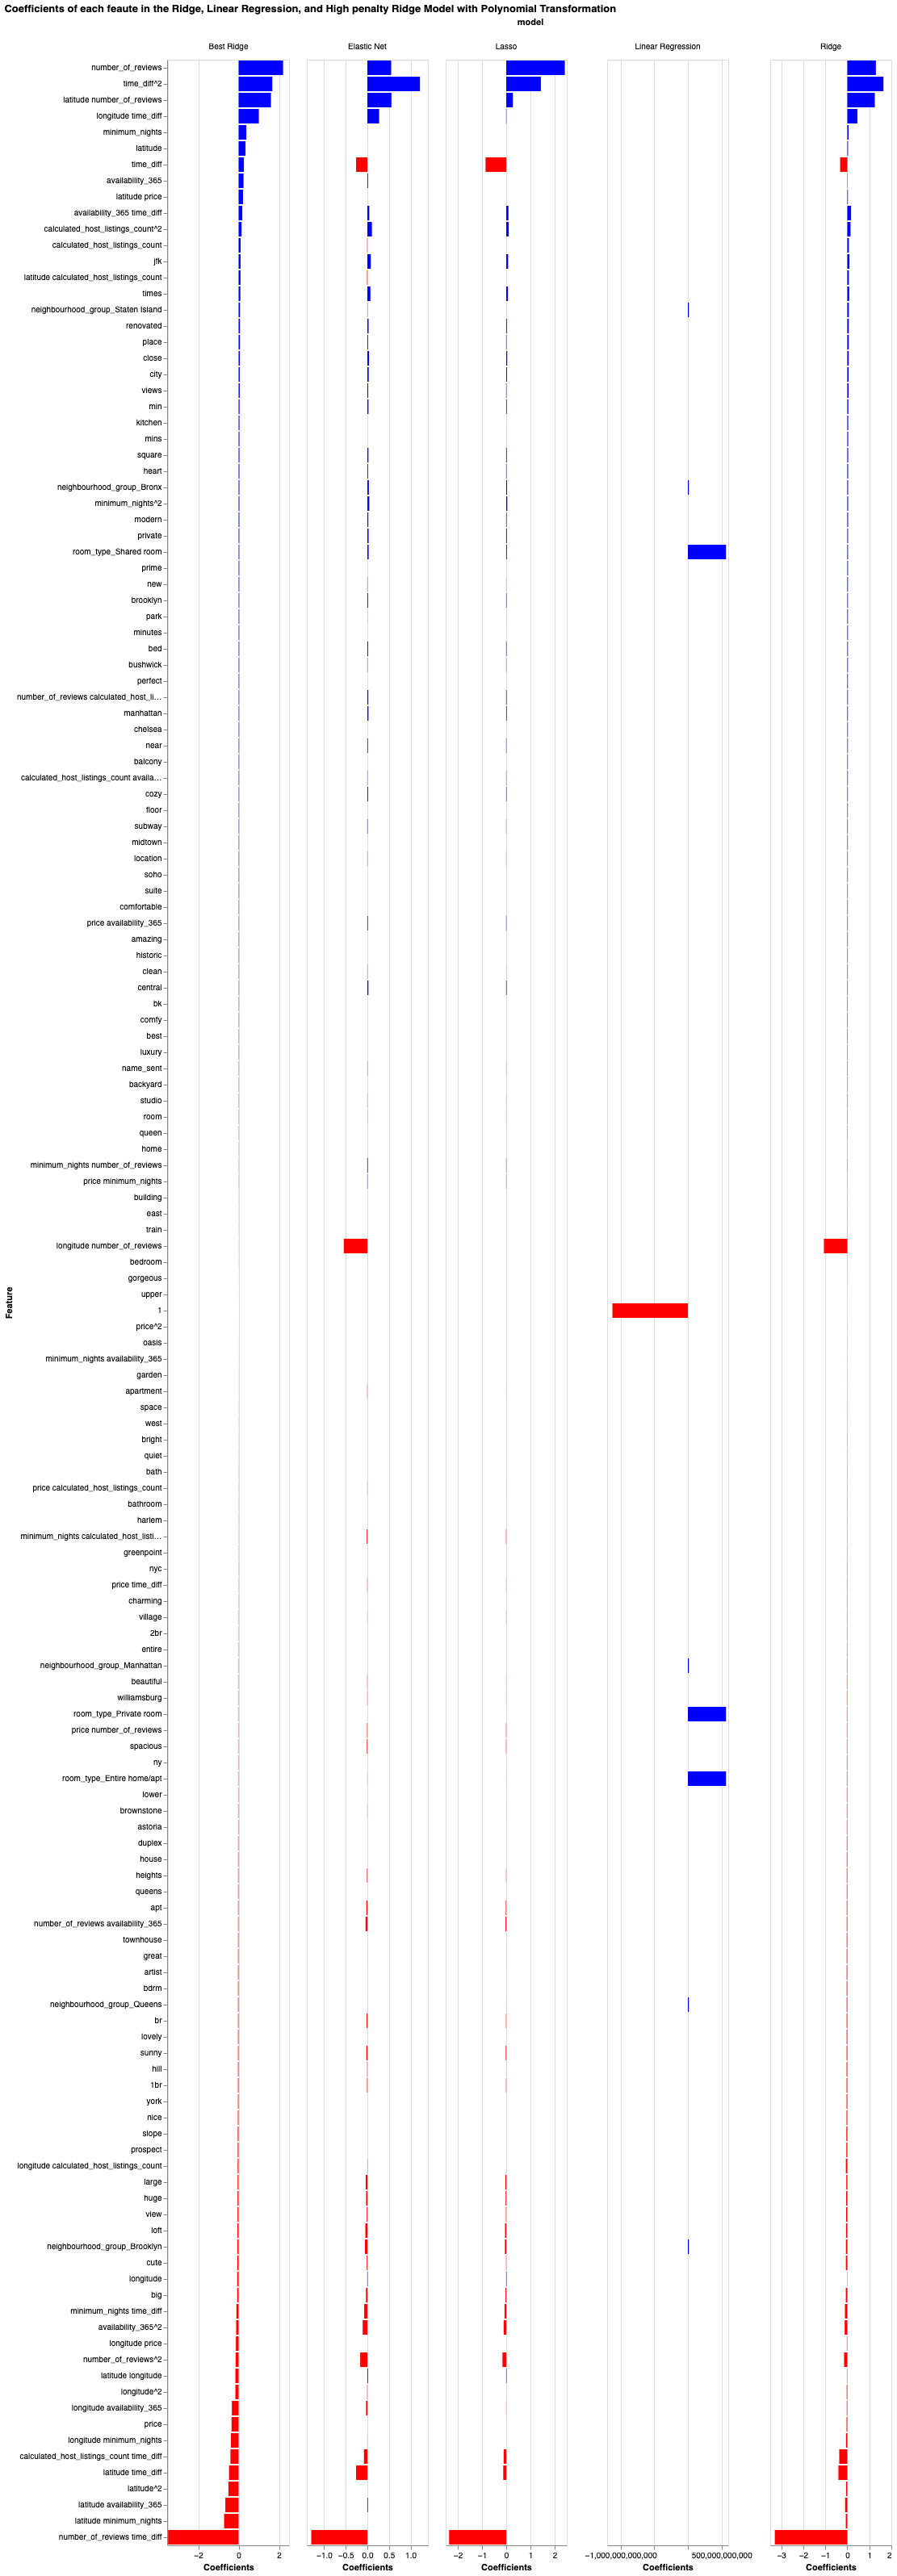

In [34]:
coefs_barplot = alt.Chart(coefs).mark_bar().encode(
    alt.X('coef', title = 'Coefficients'),
    alt.Y('variable', title = 'Feature', sort = sorted_feat_names),
    color=alt.condition(
        alt.datum.coef > 0,
        alt.value("blue"),
        alt.value("red")
    )).properties(
    width=150).facet(column='model').properties(
    title="Coefficients of each feaute in the Ridge, Linear Regression, and High penalty Ridge Model with Polynomial Transformation"
).resolve_scale(x='independent')
coefs_barplot

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 8. Different models <a name="8"></a>
rubric={accuracy,reasoning}

**Your tasks:**
1. Try out three other models aside from the linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat the performance of the linear model? 
    
</div>

_Points:_ 10

**Answer:** In this section, I tried three models:
- `SVR`: This model is a Support Vector Machine regression. It uses the same idea of the support vector machine, and instead of using the kernel to define the boundary, it uses the same method to define the line.
- `Gradient Boosting Regressor`: This model is a non-linear model for regression problems. The idea of this model is that in each iteration, it breaks the line with slope zero and fits it to the data to increase the predictions.
- `Hist Gradient Boosting Regressor`: Gradient boosting is slow, and this model is the lighter version. This model uses binning or discretization of the value to a fixed number of buckets, reducing the number of unique values and increasing the speed.

Regarding their results on the problem, they all showed better performance on the cross-validation scores. The test score increased from a range of 75% increase to the range of 82% for `SVR` model and 86% for `Gradient Boosting Regressor` and `Hist Gradient Boosting Regressor`. The `Hist Gradient Boosting Regressor` tends towards overfitting with a training score of 87% and a test score of 91%. These models generally perform better than linear models.

In terms of speed, the `SVR` and `Gradient Boosting Regressor` models take much longer than the linear models. In problems with higher dimensions, we need to consider computational resources. One way of dealing with the long run times is to use feature selection methods to reduce the dimension of the model.
For the rest of the analysis, I will use `Gradient Boosting Regressor` as the reference model.

In [35]:
# Support Vector Machine: Regression
svr_model = SVR()
svr_pipeline = make_pipeline(preprocessor, svr_model)
svr_pipeline.fit(X_train, y_train_transformed)

results["svr"] = mean_std_cross_val_scores(svr_pipeline,
                                           X_train,
                                           y_train_transformed,
                                           return_train_score=True,
                                           scoring=scoring,
                                           cv=2)

# Gradient Boosting Regressor inspired by XGBoost
gbr_model = GradientBoostingRegressor(random_state=123)
gbr_pipeline = make_pipeline(preprocessor, gbr_model)
gbr_pipeline.fit(X_train, y_train_transformed)

results["gbr"] = mean_std_cross_val_scores(gbr_pipeline,
                                           X_train,
                                           y_train_transformed,
                                           return_train_score=True,
                                           scoring=scoring,
                                           cv=2)
                                           
# Hist Gradient Boosting Regressor inspired by LightGBM
hgbr_model = HistGradientBoostingRegressor(random_state=123)
hgbr_pipeline = make_pipeline(preprocessor, hgbr_model)
hgbr_pipeline.fit(X_train, y_train_transformed)

results["hgbr"] = mean_std_cross_val_scores(hgbr_pipeline,
                                           X_train,
                                           y_train_transformed,
                                           return_train_score=True,
                                           scoring=scoring,
                                           cv=2)

In [36]:
pd.DataFrame(results)

,linear_regression,ridge,best_ridge,lasso,elastic,svr,gbr,hgbr
fit_time,0.186 (+/- 0.014),0.092 (+/- 0.001),0.093 (+/- 0.002),68.067 (+/- 93.485),32.798 (+/- 42.806),7.205 (+/- 0.509),8.277 (+/- 0.008),1.761 (+/- 0.463)
score_time,0.019 (+/- 0.000),0.019 (+/- 0.000),0.019 (+/- 0.000),0.047 (+/- 0.001),0.045 (+/- 0.000),9.871 (+/- 0.546),0.060 (+/- 0.001),0.075 (+/- 0.016)
test_R2,0.749 (+/- 0.034),0.750 (+/- 0.031),0.750 (+/- 0.032),0.730 (+/- 0.024),0.726 (+/- 0.018),0.829 (+/- 0.002),0.870 (+/- 0.002),0.875 (+/- 0.002)
train_R2,0.771 (+/- 0.002),0.769 (+/- 0.002),0.770 (+/- 0.002),0.741 (+/- 0.039),0.736 (+/- 0.033),0.866 (+/- 0.000),0.883 (+/- 0.000),0.913 (+/- 0.006)
test_NRMSE,-0.327 (+/- 0.022),-0.326 (+/- 0.021),-0.326 (+/- 0.021),-0.339 (+/- 0.015),-0.342 (+/- 0.011),-0.270 (+/- 0.002),-0.235 (+/- 0.001),-0.230 (+/- 0.002)
train_NRMSE,-0.313 (+/- 0.002),-0.314 (+/- 0.002),-0.313 (+/- 0.002),-0.332 (+/- 0.025),-0.335 (+/- 0.021),-0.239 (+/- 0.000),-0.223 (+/- 0.000),-0.192 (+/- 0.007)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 9. Feature selection (Challenging)
rubric={reasoning}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises unless you think there are other benefits with using less features.
    
</div>

_Points:_ 0.5

**Answer:** Based on the selected model `Gradient Boosting Regressor`, none of the `RFECV`, `Forward-Selection`, and `L1 regularization` is not helping in improving the score of the model. There isn't any benefit in keeping fewer features. However, using Forward and Lasso will result in 77 remaining features, and using RFECV results in 15 features which is significantly low and reduce the run-time of the `Gradient Boosting Regressor` model to a much lower value than the original Gradient Boosting Regressor run-time (from 14 seconds to 6 seconds). We'll be moving forward with the RFECV method to reduce the model size and improve the running speed. The features that were selected by the `RFECV` method are listed below, which seems compatible with the top features coefficients in the linear model!

In [37]:
# Gradient Boosting Regressor with forward feature selection
gbr_model = GradientBoostingRegressor(random_state=123)
gbr_pipeline_forward = make_pipeline(
    preprocessor,
    SequentialFeatureSelector(Ridge(), direction="forward"),
    gbr_model
)
gbr_pipeline_forward.fit(X_train, y_train_transformed)

results["gbr_fw"] = mean_std_cross_val_scores(gbr_pipeline_forward,
                                           X_train,
                                           y_train_transformed,
                                           return_train_score=True,
                                           scoring=scoring,
                                           cv=2)

# Gradient Boosting Regressor with rfecv feature selection
rfecv = RFECV(Ridge())

gbr_pipeline_rfecv = make_pipeline(
    preprocessor,
    rfecv,
    gbr_model
)
gbr_pipeline_rfecv.fit(X_train, y_train_transformed)

results["gbr_rfecv"] = mean_std_cross_val_scores(gbr_pipeline_rfecv,
                                           X_train,
                                           y_train_transformed,
                                           return_train_score=True,
                                           scoring=scoring,
                                           cv=2)

# Gradient Boosting Regressor with feature selection from Lasso model (L1 regularization)
select_lr = SelectFromModel(LassoCV(max_iter=20_000), threshold="median")

gbr_pipeline_sfm = make_pipeline(
    preprocessor,
    select_lr,
    gbr_model
)
gbr_pipeline_sfm.fit(X_train, y_train_transformed)

results["gbr_sfm"] = mean_std_cross_val_scores(gbr_pipeline_sfm,
                                           X_train,
                                           y_train_transformed,
                                           return_train_score=True,
                                           scoring=scoring,
                                           cv=2)

Below show the important features selected by `RFECV` method. As it was initially expected, some features like `minimum_nights`, `number_of_reviews`, and `time_diff` are showing here.

In [38]:
# Selected features by the RFECV method
list(gbr_pipeline_rfecv.named_steps['columntransformer'].get_feature_names_out()[gbr_pipeline_rfecv.named_steps['rfecv'].get_support()])

['pipeline__minimum_nights',
 'pipeline__number_of_reviews',
 'pipeline__time_diff',
 'pipeline__latitude number_of_reviews',
 'pipeline__longitude number_of_reviews',
 'pipeline__longitude time_diff',
 'pipeline__minimum_nights time_diff',
 'pipeline__number_of_reviews^2',
 'pipeline__number_of_reviews time_diff',
 'pipeline__calculated_host_listings_count^2',
 'pipeline__calculated_host_listings_count time_diff',
 'pipeline__availability_365^2',
 'pipeline__time_diff^2',
 'countvectorizer__jfk',
 'countvectorizer__times']

In [39]:
pd.DataFrame(results)

,linear_regression,ridge,best_ridge,lasso,elastic,svr,gbr,hgbr,gbr_fw,gbr_rfecv,gbr_sfm
fit_time,0.186 (+/- 0.014),0.092 (+/- 0.001),0.093 (+/- 0.002),68.067 (+/- 93.485),32.798 (+/- 42.806),7.205 (+/- 0.509),8.277 (+/- 0.008),1.761 (+/- 0.463),120.554 (+/- 0.062),6.529 (+/- 0.247),74.305 (+/- 81.638)
score_time,0.019 (+/- 0.000),0.019 (+/- 0.000),0.019 (+/- 0.000),0.047 (+/- 0.001),0.045 (+/- 0.000),9.871 (+/- 0.546),0.060 (+/- 0.001),0.075 (+/- 0.016),0.061 (+/- 0.000),0.058 (+/- 0.002),0.070 (+/- 0.006)
test_R2,0.749 (+/- 0.034),0.750 (+/- 0.031),0.750 (+/- 0.032),0.730 (+/- 0.024),0.726 (+/- 0.018),0.829 (+/- 0.002),0.870 (+/- 0.002),0.875 (+/- 0.002),0.870 (+/- 0.002),0.864 (+/- 0.002),0.870 (+/- 0.001)
train_R2,0.771 (+/- 0.002),0.769 (+/- 0.002),0.770 (+/- 0.002),0.741 (+/- 0.039),0.736 (+/- 0.033),0.866 (+/- 0.000),0.883 (+/- 0.000),0.913 (+/- 0.006),0.881 (+/- 0.001),0.872 (+/- 0.001),0.882 (+/- 0.001)
test_NRMSE,-0.327 (+/- 0.022),-0.326 (+/- 0.021),-0.326 (+/- 0.021),-0.339 (+/- 0.015),-0.342 (+/- 0.011),-0.270 (+/- 0.002),-0.235 (+/- 0.001),-0.230 (+/- 0.002),-0.235 (+/- 0.002),-0.240 (+/- 0.002),-0.235 (+/- 0.001)
train_NRMSE,-0.313 (+/- 0.002),-0.314 (+/- 0.002),-0.313 (+/- 0.002),-0.332 (+/- 0.025),-0.335 (+/- 0.021),-0.239 (+/- 0.000),-0.223 (+/- 0.000),-0.192 (+/- 0.007),-0.225 (+/- 0.000),-0.233 (+/- 0.001),-0.224 (+/- 0.001)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 10. Hyperparameter optimization
rubric={accuracy,reasoning}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 
    
</div>

_Points:_ 6

**Answer:** I carried out three hyperparameter optimization over three models:
- `SVR`: Very similar to the SVM RBF Kernel the hyperparameter `C` and `epsilon` are controlling the complexity of the model.
- `Gradient Boosting Regressor`: In this model, I carried out a hyperparameter optimization on the `max_depth` of the tree, and the `max_depth = 4` results in the best scores.
- `Hist Gradient Boosting Regressor`: Controlling the `max_bins` of the model's binning and complexity, higher bins decrease the complexity of the model and avoid overfitting.

It seems for the non-linear models, the hyperparameter optimization changes the train test scores by about 1-2%. In our final model, `Gradient Boosting Regressor` the hyperparameter optimization doesn't affect the results significantly while making the model more complex and increasing the run-time. So the `Gradient Boosting Regressor` default hyperparameters will be used.

In [41]:
# Gradient Boosting Regressor Hyperparameter optimization with scikit-optimize method
search_space = {"gradientboostingregressor__max_depth": (1,5)}
bayes_search_gbr = BayesSearchCV(gbr_pipeline_rfecv,
                                 search_space,
                                 scoring="r2",
                                 cv=2,
                                 n_jobs=-1,
                                 n_iter=1,
                                 verbose=0,
                                 refit=True,
                                 return_train_score = True
)
bayes_search_gbr.fit(X_train, y_train_transformed)

# Best Gradient Boosting Regressor model
best_gbr_max_depth = bayes_search_gbr.best_params_['gradientboostingregressor__max_depth']
best_gbr_model = GradientBoostingRegressor(random_state=123, max_depth=best_gbr_max_depth)
best_gbr_pipeline_rfecv = make_pipeline(
    preprocessor,
    rfecv,
    best_gbr_model
)
best_gbr_pipeline_rfecv.fit(X_train, y_train_transformed)

results["best_gbr"] = mean_std_cross_val_scores(best_gbr_pipeline_rfecv,
                                                X_train,
                                                y_train_transformed,
                                                return_train_score=True,
                                                scoring=scoring,
                                                cv=2)

# SVR Hyperparameter optimization with RandomCV search
param_dist = {"svr__C": 10.0 ** np.arange(-2, 3),
              "svr__epsilon": 10.0 ** np.arange(-2, 3)}
random_search_svr = RandomizedSearchCV(svr_pipeline,
                                       param_dist,
                                       scoring="r2",
                                       cv=2,
                                       n_jobs=-1,
                                       n_iter=1,
                                       verbose=0,
                                       refit=True,
                                       return_train_score = True,
                                       random_state = 123
)
random_search_svr.fit(X_train, y_train_transformed)

# Best SVR model
best_svr_c = random_search_svr.best_params_['svr__C']
best_svr_epsilon = random_search_svr.best_params_['svr__epsilon']
best_svr_model = SVR(C=best_svr_c, epsilon=best_svr_epsilon)
best_svr_pipeline = make_pipeline(preprocessor, best_svr_model)
best_svr_pipeline.fit(X_train, y_train_transformed)

results["best_svr"] = mean_std_cross_val_scores(best_svr_pipeline,
                                                X_train,
                                                y_train_transformed,
                                                return_train_score=True,
                                                scoring=scoring,
                                                cv=2)




# HGBR Hyperparameter optimization with GridCV search
param_grid = {"histgradientboostingregressor__max_bins": range(5,256,50)}
param_search_gbr = GridSearchCV(hgbr_pipeline,
                                param_grid,
                                scoring="r2",
                                cv=2,
                                n_jobs=-1,
                                refit=True,
                                return_train_score=True
)
param_search_gbr.fit(X_train, y_train_transformed)


# Best HGBR model
best_hgbr_max_bins = param_search_gbr.best_params_['histgradientboostingregressor__max_bins']
best_hgbr_model = HistGradientBoostingRegressor(random_state=123, max_bins=best_hgbr_max_bins)
best_hgbr_pipeline = make_pipeline(preprocessor, best_hgbr_model)
best_hgbr_pipeline.fit(X_train, y_train_transformed)

results["best_hgbr"] = mean_std_cross_val_scores(best_hgbr_pipeline,
                                                X_train,
                                                y_train_transformed,
                                                return_train_score=True,
                                                scoring=scoring,
                                                cv=2)

pd.DataFrame(results)

,linear_regression,ridge,best_ridge,lasso,elastic,svr,gbr,hgbr,gbr_fw,gbr_rfecv,gbr_sfm,best_gbr,best_svr,best_hgbr
fit_time,0.186 (+/- 0.014),0.092 (+/- 0.001),0.093 (+/- 0.002),68.067 (+/- 93.485),32.798 (+/- 42.806),7.205 (+/- 0.509),8.277 (+/- 0.008),1.761 (+/- 0.463),120.554 (+/- 0.062),6.529 (+/- 0.247),74.305 (+/- 81.638),5.627 (+/- 0.249),8.886 (+/- 0.155),1.612 (+/- 0.386)
score_time,0.019 (+/- 0.000),0.019 (+/- 0.000),0.019 (+/- 0.000),0.047 (+/- 0.001),0.045 (+/- 0.000),9.871 (+/- 0.546),0.060 (+/- 0.001),0.075 (+/- 0.016),0.061 (+/- 0.000),0.058 (+/- 0.002),0.070 (+/- 0.006),0.053 (+/- 0.001),13.144 (+/- 0.003),0.066 (+/- 0.008)
test_R2,0.749 (+/- 0.034),0.750 (+/- 0.031),0.750 (+/- 0.032),0.730 (+/- 0.024),0.726 (+/- 0.018),0.829 (+/- 0.002),0.870 (+/- 0.002),0.875 (+/- 0.002),0.870 (+/- 0.002),0.864 (+/- 0.002),0.870 (+/- 0.001),0.860 (+/- 0.002),0.799 (+/- 0.001),0.875 (+/- 0.002)
train_R2,0.771 (+/- 0.002),0.769 (+/- 0.002),0.770 (+/- 0.002),0.741 (+/- 0.039),0.736 (+/- 0.033),0.866 (+/- 0.000),0.883 (+/- 0.000),0.913 (+/- 0.006),0.881 (+/- 0.001),0.872 (+/- 0.001),0.882 (+/- 0.001),0.864 (+/- 0.000),0.811 (+/- 0.001),0.913 (+/- 0.006)
test_NRMSE,-0.327 (+/- 0.022),-0.326 (+/- 0.021),-0.326 (+/- 0.021),-0.339 (+/- 0.015),-0.342 (+/- 0.011),-0.270 (+/- 0.002),-0.235 (+/- 0.001),-0.230 (+/- 0.002),-0.235 (+/- 0.002),-0.240 (+/- 0.002),-0.235 (+/- 0.001),-0.245 (+/- 0.002),-0.293 (+/- 0.001),-0.230 (+/- 0.002)
train_NRMSE,-0.313 (+/- 0.002),-0.314 (+/- 0.002),-0.313 (+/- 0.002),-0.332 (+/- 0.025),-0.335 (+/- 0.021),-0.239 (+/- 0.000),-0.223 (+/- 0.000),-0.192 (+/- 0.007),-0.225 (+/- 0.000),-0.233 (+/- 0.001),-0.224 (+/- 0.001),-0.241 (+/- 0.000),-0.284 (+/- 0.001),-0.192 (+/- 0.007)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 11. Interpretation and feature importances <a name="1"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 
    
</div>

_Points:_ 8

**Answer:** In this section, I have used the `eli5` method to examine the feature importances for the `Gradient Boosting Regressor` model. Based on the feature weight we observe in the `eli5` method, we see similar features that were selected by the `RFECV` method in the feature engineering section. It seems that `minimum_nights`, `number_of_reviews`, and `time_diff` are the top contributors to the target prediction. The weight magnitude is low and it can be concluded that this model generalizes well. By seeing the polynomial transformation result on top of the list, we came to the point that the non-linear models are lacking clear interpretability and the seemingly more complex to digest. Their nature is like a black box and it's hard to understand the coefficients of each feature. Despite our initial guess of seeing features like `minimum_nights`, `number_of_reviews`, and `time_diff`, we don't observe any of the mentioned features here.

In [44]:
# Reduced model feture weights
feature_names = list(gbr_pipeline.named_steps['columntransformer'].get_feature_names_out())
eli5.explain_weights(gbr_pipeline.named_steps['gradientboostingregressor'], feature_names=feature_names)

Weight,Feature
0.3873 ± 0.3464,pipeline__longitude time_diff
0.2467 ± 0.3222,pipeline__number_of_reviews time_diff
0.1440 ± 0.2710,pipeline__time_diff^2
0.1027 ± 0.2583,pipeline__time_diff
0.0643 ± 0.3069,pipeline__latitude time_diff
0.0223 ± 0.1483,pipeline__longitude minimum_nights
0.0076 ± 0.1865,pipeline__latitude number_of_reviews
0.0030 ± 0.1423,pipeline__price minimum_nights
0.0026 ± 0.0833,pipeline__latitude minimum_nights
0.0024 ± 0.0510,pipeline__number_of_reviews availability_365


In [48]:
# Full model feture weights
gbr_pipeline_rfecv.fit(X_train, y_train_transformed)
feature_names_reduced = list(gbr_pipeline_rfecv.named_steps['columntransformer'].get_feature_names_out()[gbr_pipeline_rfecv.named_steps['rfecv'].get_support()])
eli5.explain_weights(gbr_pipeline_rfecv.named_steps['gradientboostingregressor'], feature_names=feature_names_reduced)

Weight,Feature
0.4034 ± 0.3679,pipeline__longitude time_diff
0.2537 ± 0.3545,pipeline__number_of_reviews time_diff
0.1722 ± 0.3440,pipeline__time_diff
0.1243 ± 0.3078,pipeline__time_diff^2
0.0199 ± 0.2790,pipeline__minimum_nights time_diff
0.0100 ± 0.2365,pipeline__latitude number_of_reviews
0.0080 ± 0.1381,pipeline__minimum_nights
0.0041 ± 0.3093,pipeline__availability_365^2
0.0015 ± 0.1755,pipeline__longitude number_of_reviews
0.0012 ± 0.1555,pipeline__calculated_host_listings_count time_diff


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 12. Results on the test set <a name="12"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  
    
</div>

_Points:_ 6

**Answer:** The test score is about 87% which is very close to the cross-validation test scores and this shows that this model generalizes fairly well. Using linear models might seem more intuitive and easy to understand since we saw some features like `minimum_nights`, `number_of_reviews`, and `time_diff` are contributing most in the prediction weights. In reality having more reviews signals that the rental is active and more people renting it and leaving their comments, while this naturally affects the target which is the number of reviews per month. Having lower minimum night shows again represents more activity of the property and a higher number of reviews per month. Also receiving more recent reviews signals the model's properties activity in the past and hints at more reviews per month.

In [49]:
gbr_pipeline_rfecv.score(X_test, y_test_transformed)

0.8731134043936982

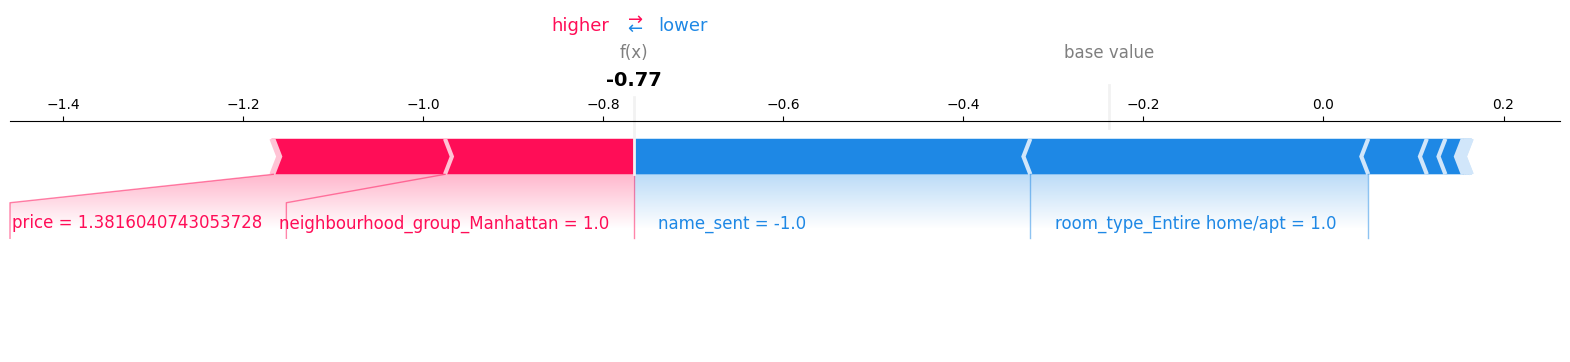

In [50]:
shap.initjs()
X_test_enc = pd.DataFrame(
    data=preprocessor.fit_transform(X_test),
    columns=features_transformed,
    index=X_test.index,
)
gbr_explainer = shap.TreeExplainer(gbr_pipeline_rfecv.named_steps['gradientboostingregressor'])
train_gbr_shap_values = gbr_explainer.shap_values(X_test_enc)
gbr_explainer.expected_value

shap.force_plot(
    gbr_explainer.expected_value[0],
    train_gbr_shap_values[15528],
    X_test_enc.iloc[15528],
    matplotlib=True,
)

In the example above, we see some features forcing the prediction to be about -0.77. In this prediction `name_sent` contributes most an then `room_type` contributes next. On the other hand the against forces are the `neighbourhood_group` and `price` which the tend to force the prediction towards the base value.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 13. Summary of results <a name="13"></a>
rubric={reasoning}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook.
    
</div>

_Points:_ 8

**Answer:**
| Stage | Important Result
| --- | -----------
| EDA and Data Wrangling | In this mini-project, I tried a variety of different linear and non-linear models on a regression problem. We were specifically interested in predicting `reviews_per_month` per month for Airbnb rentals in New York City. Predicting the `reviews_per_month` and presenting it to the hosts play a critical role in their effort to collect reviews and boost their listing. By performing the initial EDA, it can be inferred that the `number_of_reviews` shows a good correlation with `reviews_per_month` and it's quite interpretable too. The higher the `number_of_reviews`, the higher the properties activity, and the higher `reviews_per_month`. The target values are skewed and transforming them with the `log` function, increased the model's accuracy by about 40%.
| Feature Engineering | As this step, extracting two features: `time_diff` and `name_sent` was created. It seems that `time_diff` contributes to the model's accuracy and `name_sent` is not making a big difference here.
| Feature Transformation | The most critical result of this section is analyzing the distribution of the `neighborhood` feature and deciding to drop this feature in order to decrease the computational load and dimension of the model.
| Baseline and Linear Models | Running `linear regression` and other linear models with `L1` and `L2` regularization shows that the performance of the linear models is about 75% while offering interpretable results making sense in the real world. `L2` regularization offers the most promising results in comparison to the other linear models.
| Non-Linear Models | Using non-linear models like `SVR`, `Gradient Boosting Regressor`, and `Hist Gradient Boosting Regressor` opens another door to the model's performance while sacrificing the simplicity and interpretability of the results. These models on average increase the accuracy by 10% to 15%.
| Feature Selection | Using the `RFECV` method for feature selection reports `minimum_nights`, `number_of_reviews`, and `time_diff` as the most influential metrics they also make sense too.
| Hyperparameter Optimization | Carrying out hyperparameter optimization results in very close train and test scores which in fact ensures us that we are not leaning toward the optimization bias.


Throughout this mini-project, there were several times that the interpretability-accuracy trade-off was obvious and the main lesson learned from this project was seeing how different models are responding to the real problem we are trying to solve. For this particular problem using non-linear would be a better choice due to the nature of the problem (building a recommendation engine to motivate the hosts to collect more reviews). To improve the results, using model combinations lie stacking, or voting systems would be helpful. So having a balance between linear and non-linear models will provide an opportunity to improve the accuracy while having the model interpretable enough.

Based on the result table below, choosing the `Gradient Boosting Regressor` with the combination of the `RFECV` feature selector, provides a lower run-time, simpler model, and higher accuracy (87% train score, 86% test score). We also need to note that using non-linear models and complex models may result in overfitting. 

In [51]:
pd.DataFrame(results)

,linear_regression,ridge,best_ridge,lasso,elastic,svr,gbr,hgbr,gbr_fw,gbr_rfecv,gbr_sfm,best_gbr,best_svr,best_hgbr
fit_time,0.186 (+/- 0.014),0.092 (+/- 0.001),0.093 (+/- 0.002),68.067 (+/- 93.485),32.798 (+/- 42.806),7.205 (+/- 0.509),8.277 (+/- 0.008),1.761 (+/- 0.463),120.554 (+/- 0.062),6.529 (+/- 0.247),74.305 (+/- 81.638),5.627 (+/- 0.249),8.886 (+/- 0.155),1.612 (+/- 0.386)
score_time,0.019 (+/- 0.000),0.019 (+/- 0.000),0.019 (+/- 0.000),0.047 (+/- 0.001),0.045 (+/- 0.000),9.871 (+/- 0.546),0.060 (+/- 0.001),0.075 (+/- 0.016),0.061 (+/- 0.000),0.058 (+/- 0.002),0.070 (+/- 0.006),0.053 (+/- 0.001),13.144 (+/- 0.003),0.066 (+/- 0.008)
test_R2,0.749 (+/- 0.034),0.750 (+/- 0.031),0.750 (+/- 0.032),0.730 (+/- 0.024),0.726 (+/- 0.018),0.829 (+/- 0.002),0.870 (+/- 0.002),0.875 (+/- 0.002),0.870 (+/- 0.002),0.864 (+/- 0.002),0.870 (+/- 0.001),0.860 (+/- 0.002),0.799 (+/- 0.001),0.875 (+/- 0.002)
train_R2,0.771 (+/- 0.002),0.769 (+/- 0.002),0.770 (+/- 0.002),0.741 (+/- 0.039),0.736 (+/- 0.033),0.866 (+/- 0.000),0.883 (+/- 0.000),0.913 (+/- 0.006),0.881 (+/- 0.001),0.872 (+/- 0.001),0.882 (+/- 0.001),0.864 (+/- 0.000),0.811 (+/- 0.001),0.913 (+/- 0.006)
test_NRMSE,-0.327 (+/- 0.022),-0.326 (+/- 0.021),-0.326 (+/- 0.021),-0.339 (+/- 0.015),-0.342 (+/- 0.011),-0.270 (+/- 0.002),-0.235 (+/- 0.001),-0.230 (+/- 0.002),-0.235 (+/- 0.002),-0.240 (+/- 0.002),-0.235 (+/- 0.001),-0.245 (+/- 0.002),-0.293 (+/- 0.001),-0.230 (+/- 0.002)
train_NRMSE,-0.313 (+/- 0.002),-0.314 (+/- 0.002),-0.313 (+/- 0.002),-0.332 (+/- 0.025),-0.335 (+/- 0.021),-0.239 (+/- 0.000),-0.223 (+/- 0.000),-0.192 (+/- 0.007),-0.225 (+/- 0.000),-0.233 (+/- 0.001),-0.224 (+/- 0.001),-0.241 (+/- 0.000),-0.284 (+/- 0.001),-0.192 (+/- 0.007)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 14. Creating a data analysis pipeline (Challenging)
rubric={reasoning}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. Submit your project folder in addition to this notebook on GitHub and briefly comment on your organization in the text box below.
    
</div>

_Points:_ 2

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 15. Your takeaway from the course (Challenging)
rubric={reasoning}

**Your tasks:**

What is your biggest takeaway from this course? 
    
</div>

_Points:_ 0.25

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<div class="alert alert-danger" style="color:black">
    
**Restart, run all and export a PDF before submitting**
    
Before submitting,
don't forget to run all cells in your notebook
to make sure there are no errors
and so that the TAs can see your plots on Gradescope.
You can do this by clicking the ▶▶ button
or going to `Kernel -> Restart Kernel and Run All Cells...` in the menu.
This is not only important for MDS,
but a good habit you should get into before ever committing a notebook to GitHub,
so that your collaborators can run it from top to bottom
without issues.
    
After running all the cells,
export a PDF of the notebook (preferably the WebPDF export)
and upload this PDF together with the ipynb file to Gradescope
(you can select two files when uploading to Gradescope)
</div>

---

## Help us improve the labs

The MDS program is continually looking to improve our courses, including lab questions and content. The following optional questions will not affect your grade in any way nor will they be used for anything other than program improvement:

1. Approximately how many hours did you spend working or thinking about this assignment (including lab time)?

#Ans: 14 Hours.

2. Do you have any feedback on the lab you be willing to share? For example, any part or question that you particularly liked or disliked?

#Ans: I really enjoyed goring through this assignment as if I was reviewing all of the lectures of 571 and 573 while getting prepared for 572.